## Download data & install python packages

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    ! wget -O sensor.zip https://www.dropbox.com/sh/2umy3ajl9clwpyx/AAD1wZ2lRtvwFeZLQcMFeSMea?dl=1
    ! unzip sensor.zip
    ! pip install pandas numpy plotly matplotlib
    
    data_path = '.'
else:
    try:
        from local_settings import data_path  # noqa
    except ImportError:
        data_path = '.'

## Load dataframe

In [2]:
import os

import numpy as np
import pandas as pd
import plotly.graph_objects as go


def load_files(path, file_names=None, return_file_names=False):
    if file_names is None:
        file_names = [fn for fn in os.listdir(path) if fn.endswith('.txt')]
        if return_file_names:
            return file_names

    columns = ['timestamp'] + [f'int{i}' for i in range(8)] + [f'float{i}' for i in range(2)]
    df = pd.concat([
        pd.read_csv(os.path.join(path, fn), delimiter="\t", on_bad_lines='skip', names=columns, header=None)
        for fn in file_names], ignore_index=True)
    df.timestamp = pd.to_datetime(df.timestamp)
    df = df.sort_values('timestamp').reset_index(drop=True)
    df = df[df.timestamp.notna()]
    if not len(df):
        raise RuntimeError('No data')
    return df


fns = load_files(data_path, return_file_names=True)
print(fns)

['2022-06-29 14_33_33.txt', '2022-07-01 17_44_15.txt', '2022-07-04 11_51_19.txt', '2022-06-30 14_00_10.txt', '2022-07-01 10_19_01.txt', '2022-07-01 14_45_35.txt', '2022-07-01 11_38_19.txt', '2022-06-30 14_28_04.txt', '2022-07-01 18_12_26.txt', '2020-08-31 10_50_26.txt', '2020-08-25 14_39_15.txt', '2022-07-04 02_46_12.txt', '2022-07-04 12_18_29.txt', '2022-07-01 13_53_59.txt', '2022-06-30 13_55_27.txt', '2020-08-25 14_27_01.txt', '2022-07-01 11_42_16.txt']


In [3]:
df = load_files(data_path)  # , [fn for fn in fns if fn.startswith('2022')])

In [4]:
def scatter(data_frame, coordinate_functions, color_function=None, size_function=None, **kwargs):
    if not color_function:
        color_function = lambda x: pd.to_numeric(x.timestamp) // 1e9
    if not callable(color_function):
        cf = color_function
        color_function = lambda _: cf
    if not size_function:
        size_function = 2
    if not callable(size_function):
        sf = size_function
        size_function = lambda _: sf
    kwargs.update({
        'marker': dict(
            color=color_function(data_frame),
            size=size_function(data_frame)),
        'customdata': data_frame[data_frame.columns],
        'hovertemplate': '<br>'.join([str(k) + ':%{customdata[' + str(i) + ']}'
                                      for i, k in enumerate(data_frame.columns)])
    })

    if len(coordinate_functions) == 2:
        return go.Scatter(**{label: f(data_frame)
                             for label, f in zip(['x', 'y'], coordinate_functions)}, **kwargs)
    if len(coordinate_functions) == 3:
        return go.Scatter3d(**{label: f(data_frame)
                               for label, f in zip(['x', 'y', 'z'], coordinate_functions)}, **kwargs)

## Visualize data in 3 axes

In [5]:
coordinate_functions = [lambda x: np.log(x[f'int{2}']),
                        lambda x: np.log(x[f'int{3}']),
                        lambda x: np.log(x[f'int{7}'])]
data = df[df.timestamp>"2022-07-02"][::150]

fig = go.Figure()
fig.add_trace(scatter(data, coordinate_functions, size_function=2, mode='markers'))
# fig.add_trace(scatter(data[(data.timestamp.dt.strftime('%Y-%m-%dT%H:%M:%S') < '2022-07-02T13:00:00') *
#                            (data.timestamp.dt.strftime('%Y-%m-%dT%H:%M:%S') > '2022-07-02T12:00:00')], 
#                       coordinate_functions, color_function='red', mode='markers'))
# fig.add_trace(scatter(data[(data.timestamp.dt.strftime('%Y-%m-%dT%H:%M:%S') < '2022-07-03T06:00:00') *
#                            (data.timestamp.dt.strftime('%Y-%m-%dT%H:%M:%S') > '2022-07-03T05:00:00')], 
#                       coordinate_functions, color_function='blue', mode='markers'))
fig['layout'].update(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

## Visualize as timeseries

In [6]:
data = df[df.timestamp>"2022-06-30"][::300]  # [df.timestamp<"2022-07-04"]

fig = go.Figure()
for i in range(8):
    coordinate_functions = [lambda x: x.timestamp,
                            lambda x: np.log(x[f'int{i}'])]
    fig.add_trace(scatter(data, coordinate_functions, mode='lines'))
for i in range(2):
    coordinate_functions = [lambda x: x.timestamp,
                            lambda x: np.log(x[f'float{i}']) + 6]
    fig.add_trace(scatter(data, coordinate_functions, mode='lines'))
fig['layout'].update(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

## Plot histograms

<Figure size 432x288 with 0 Axes>

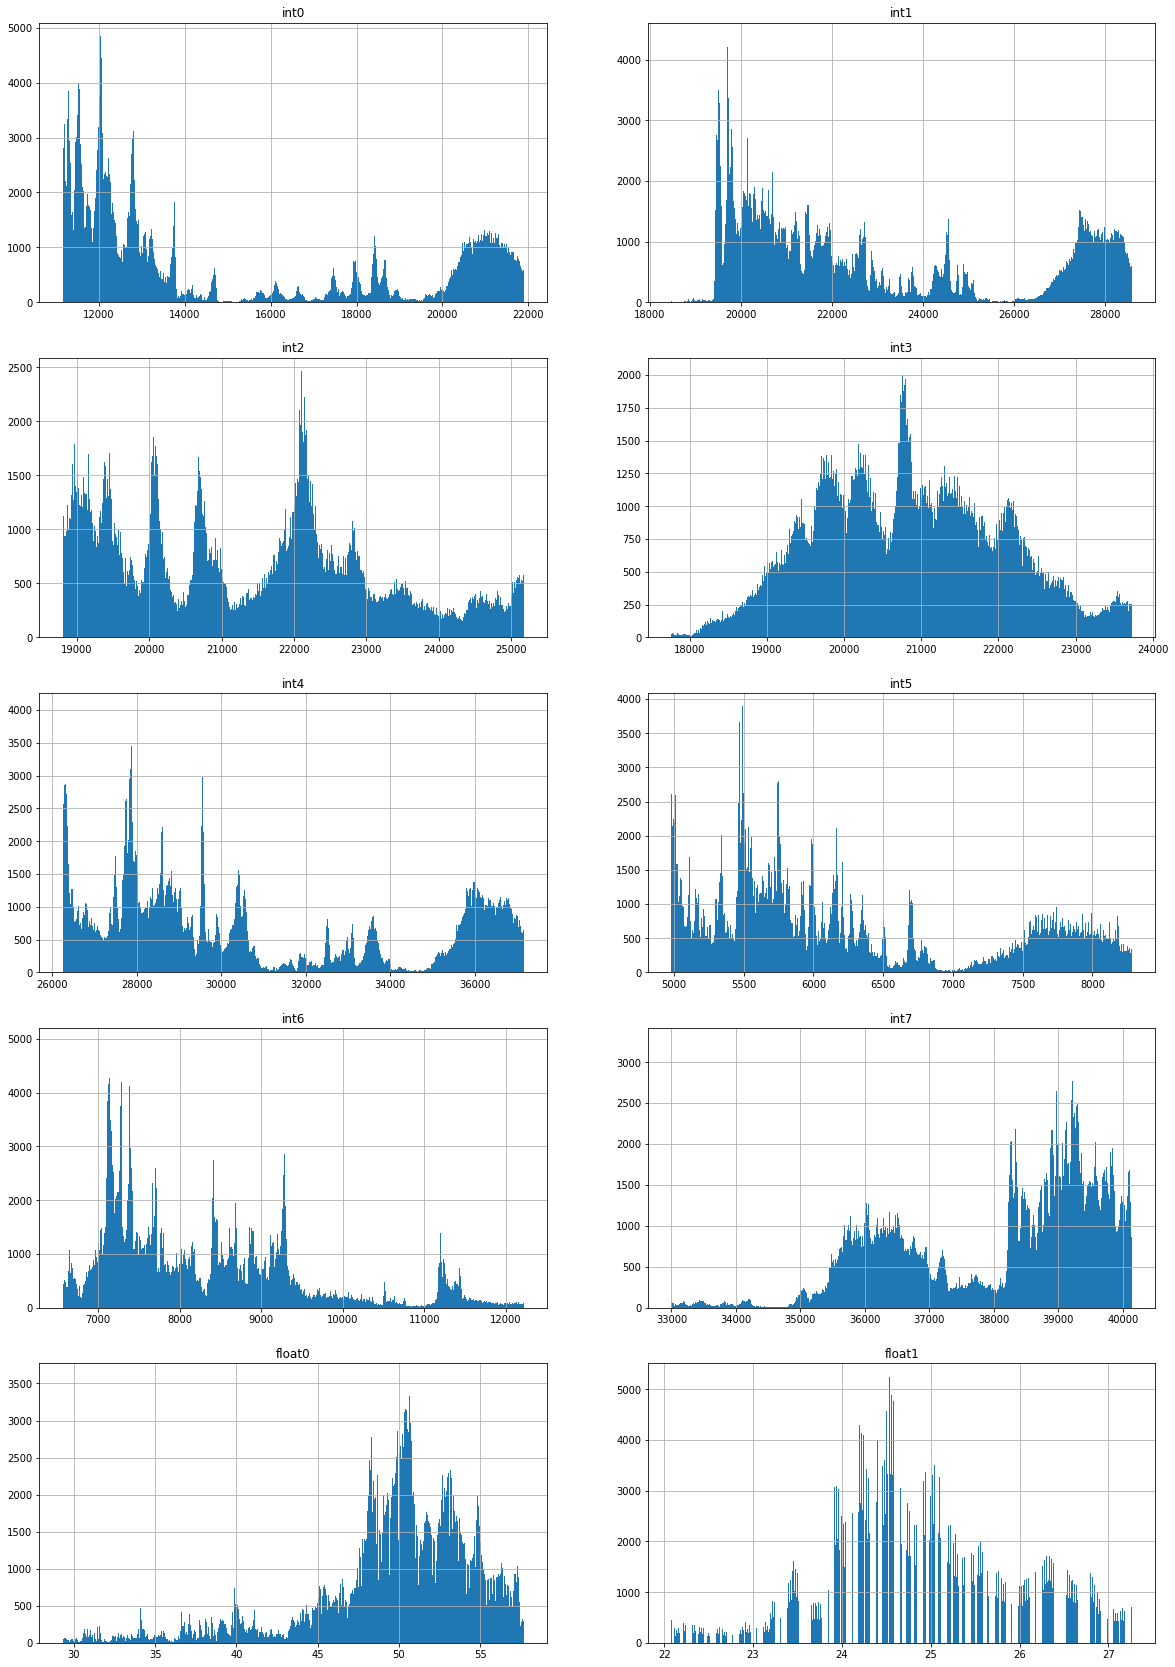

In [7]:
import matplotlib.pyplot as plt
plt.clf()

columns = df.columns[1:]

fig, axes = plt.subplots(len(columns)//2, 2, figsize=(20, 12))
fig.subplots_adjust(top=2)

i = 0
for triaxis in axes:
    for axis in triaxis:
        key = columns[i]
        df[key][(df[key] < df[key].quantile(.95)) * (df[key] > df[key].quantile(.01))].hist(bins=1000, ax=axis)
        axis.set_title(key)
        i = i+1

## ...